In [20]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


Загрузим данные

In [21]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Объеденим тренировочную и контрольную таблицу в одну

In [24]:
train['label'] = 1
test['label'] = 0
default = train['default']

In [25]:
df = pd.concat([(train.drop('default', axis=1)), test])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

Заметим пропуски только в столбце образования(education). Избавимся от них.

In [27]:
df['education'].value_counts(normalize = True)

SCH    0.528841
GRD    0.317024
UGR    0.134476
PGR    0.017006
ACD    0.002653
Name: education, dtype: float64

In [28]:
df['education'].isnull().value_counts()

False    109670
True        478
Name: education, dtype: int64

Так как отсутствующих днных всвего 0,43% заполним пропуски самым популярным значением - SCH.

In [29]:
df['education'] = df['education'].fillna('SCH')

# Распределим данные на категории

In [30]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'region_rating', 'app_date']

## Бинарные данные

Присвоим каждому значению в этих даных числовой эквивалент.

In [31]:
label_encoder = LabelEncoder()
for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])

In [32]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,label
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,1
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,1
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,1
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,1
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,1


## Категориальные данные

Преобразуем строковые значения в столбце education в числовые эквиваленты.

In [33]:
df['education'] = label_encoder.fit_transform(df['education'])

In [34]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[df['label'] == 1][cat_cols].values)

Посмтрим значимость категориальных признаков для переменной default

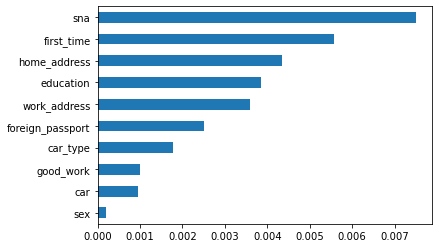

In [35]:
imp_cat = Series(mutual_info_classif(df[df['label'] == 1][bin_cols + cat_cols], default,
                                    discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наиболее значимым признаком является sna(связь заемщика с клиентами банка)

## Числовые данные

Посмотрим графики обычных и логарифмированных величин

### 1. age

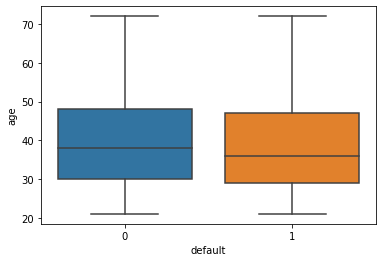

In [36]:
sns.boxplot(x="default", y="age", data=pd.concat([df[df['label'] == 1], default], axis = 1))

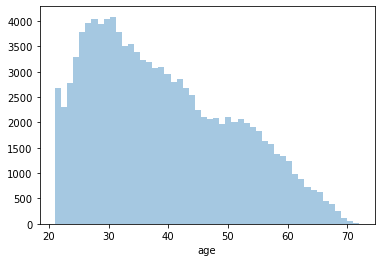

In [37]:
sns.distplot(df['age'], kde = False, rug=False)

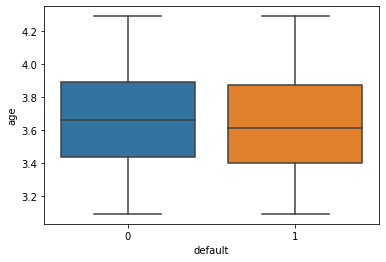

In [38]:
sns.boxplot(x="default", y=np.log1p(pd.concat([df[df['label'] == 1], default], axis = 1)['age']), data=pd.concat([df[df['label'] == 1], default], axis = 1))

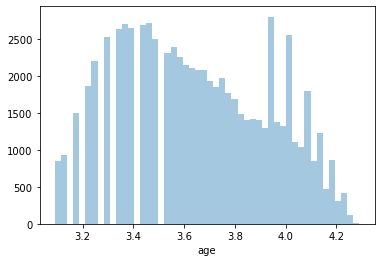

In [39]:
sns.distplot(np.log1p(train['age']), kde = False, rug=False)

### 2. decline_app_cnt

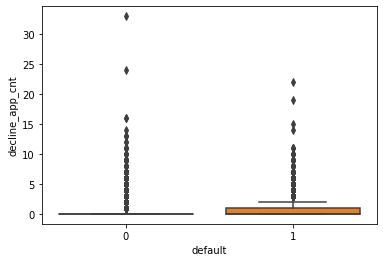

In [40]:
sns.boxplot(x="default", y="decline_app_cnt", data=pd.concat([df[df['label'] == 1], default], axis = 1))

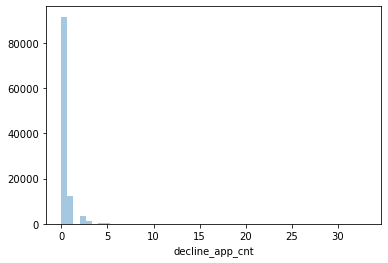

In [41]:
sns.distplot(df['decline_app_cnt'], kde = False, rug=False)

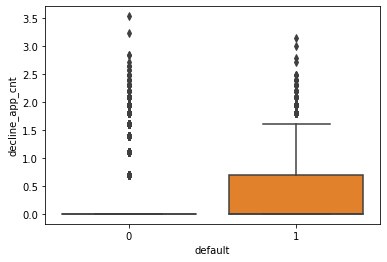

In [42]:
sns.boxplot(x="default", y=np.log1p(pd.concat([df[df['label'] == 1], default], axis = 1)["decline_app_cnt"]), data=pd.concat([df[df['label'] == 1], default], axis = 1))

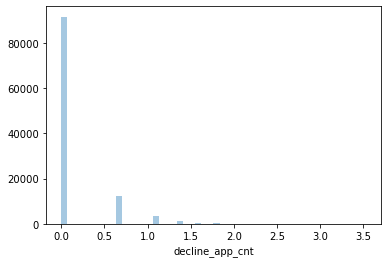

In [43]:
sns.distplot(np.log1p(df["decline_app_cnt"]), kde = False, rug=False)

Характер распределения не изменился, выбросы остались.

### 3. income

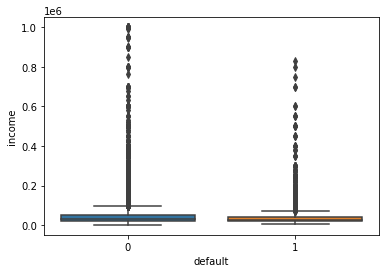

In [44]:
sns.boxplot(x="default", y="income", data=pd.concat([df[df['label'] == 1], default], axis = 1))

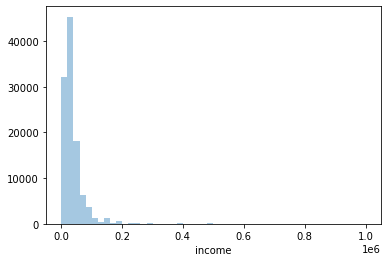

In [45]:
sns.distplot(df['income'], kde = False, rug=False)

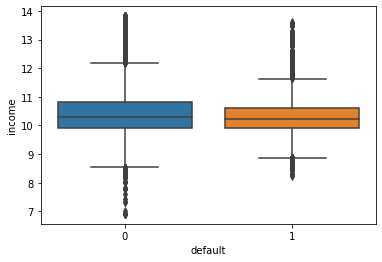

In [46]:
sns.boxplot(x="default", y=np.log1p(pd.concat([df[df['label'] == 1], default], axis = 1)["income"]), data=pd.concat([df[df['label'] == 1], default], axis = 1))

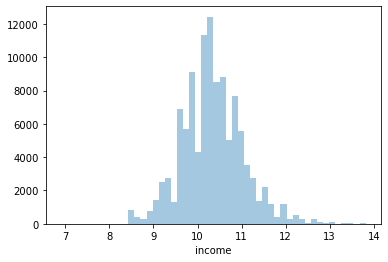

In [47]:
sns.distplot(np.log1p(df["income"]), kde = False, rug=False)

Выбросы остались, ярковыраженный логнармальное распредление

### 4. bki_request_cnt

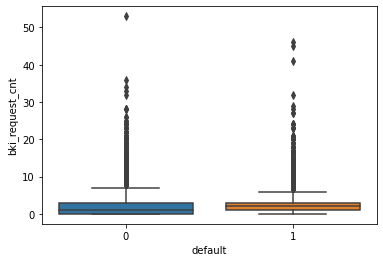

In [48]:
sns.boxplot(x="default", y="bki_request_cnt", data=pd.concat([df[df['label'] == 1], default], axis = 1))

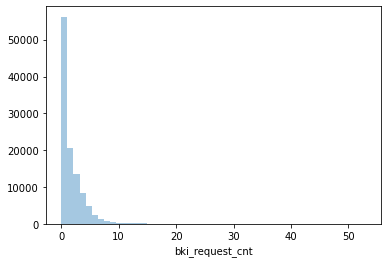

In [49]:
sns.distplot(df['bki_request_cnt'], kde = False, rug=False)

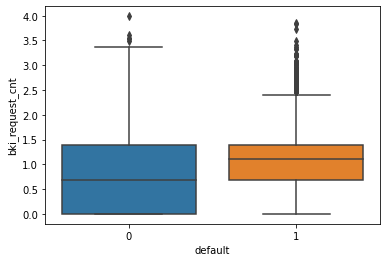

In [50]:
sns.boxplot(x="default", y=np.log1p(pd.concat([df[df['label'] == 1], default], axis = 1)["bki_request_cnt"]), data=pd.concat([df[df['label'] == 1], default], axis = 1))

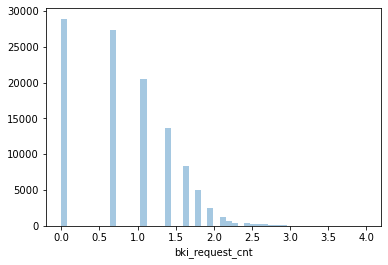

In [51]:
sns.distplot(np.log1p(df["bki_request_cnt"]), kde = False, rug=False)

### 5. score_bki

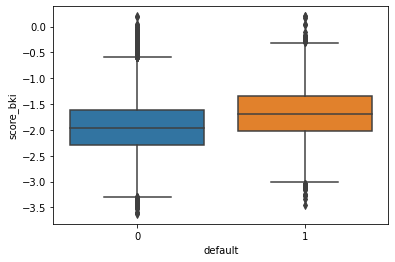

In [52]:
sns.boxplot(x="default", y="score_bki", data=pd.concat([df[df['label'] == 1], default], axis = 1))

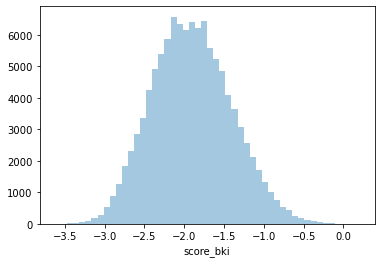

In [53]:
sns.distplot(df['score_bki'], kde = False, rug=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


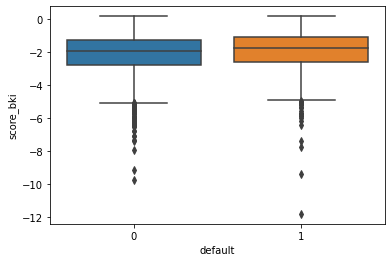

In [54]:
sns.boxplot(x="default", y=np.log1p(pd.concat([df[df['label'] == 1], default], axis = 1)["score_bki"]), data=pd.concat([df[df['label'] == 1], default], axis = 1))

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


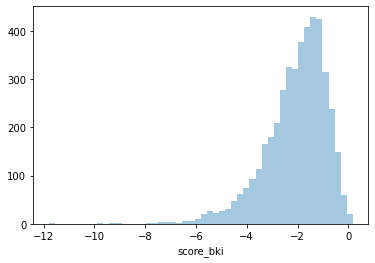

In [55]:
sns.distplot(np.log1p(df["score_bki"]), kde = False, rug=False)

Ярковыраженное нормальное распредление.

### 6. region_rating

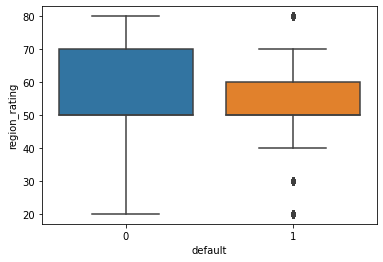

In [56]:
sns.boxplot(x="default", y="region_rating", data=pd.concat([df[df['label'] == 1], default], axis = 1))

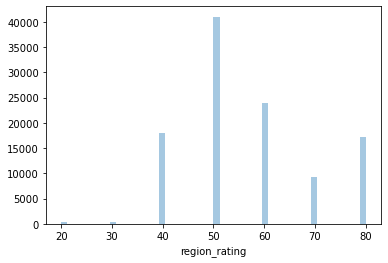

In [57]:
sns.distplot(df['region_rating'], kde = False, rug=False)

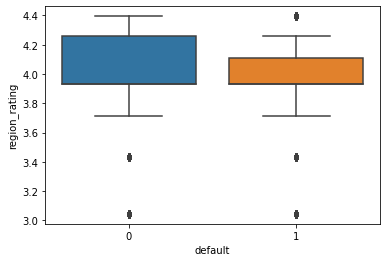

In [58]:
sns.boxplot(x="default", y=np.log1p(pd.concat([df[df['label'] == 1], default], axis = 1)["region_rating"]), data=pd.concat([df[df['label'] == 1], default], axis = 1))

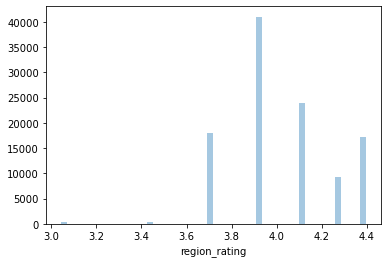

In [59]:
sns.distplot(np.log1p(df["region_rating"]), kde = False, rug=False)

### 7. app_date

На основе этого признака следует построить новый.

In [60]:
df["app_date"] = df["app_date"].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [61]:
min_data = df['app_date'].min()
max_data = df['app_date'].max()

In [62]:
print(min_data)
print(max_data)

2014-01-01 00:00:00
2014-04-30 00:00:00


Период довольно короткий для оценки каких либо периодов. Поэтому просто выразим количество дней, от начала наблюдений, до даты заявки.

In [63]:
df['days'] = df['app_date'] - min_data

In [64]:
df['days'] = df['days'].apply(lambda x: int(x.days))

In [65]:
num_cols.append('days')
num_cols.remove('app_date')

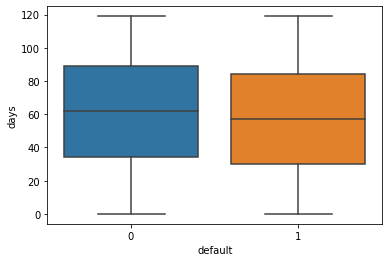

In [66]:
sns.boxplot(x="default", y="days", data=pd.concat([df[df['label'] == 1], default], axis = 1))

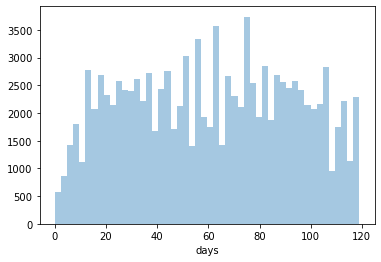

In [67]:
sns.distplot(df['days'], kde = False, rug=False)

**В результате прологарифмируем два столбца: age и income**

In [68]:
df['age'] = np.log1p(df['age'])
df['income'] = np.log1p(df['income'])

Оценим карреляцию

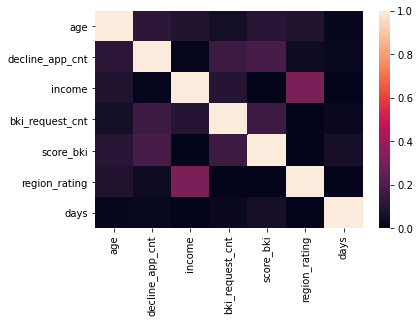

In [69]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Сильной корреляции не наблюдается. Оставляем данные.

Стандартизируем наши данные

In [71]:
X_num = StandardScaler().fit_transform(df[df['label'] == 1][num_cols].values)

In [72]:
X = np.hstack([X_num, df[df['label'] == 1][bin_cols].values, X_cat])
Y = default.values

Разделим выборку на тренировочную и вылидационнную.

In [76]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


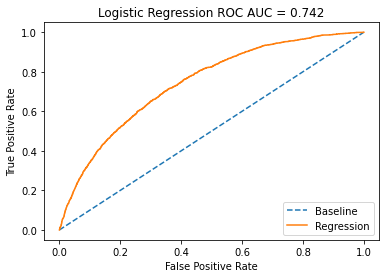

In [77]:
model = LogisticRegression()
model.fit(X_train, Y_train)

probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_val, probs)
roc_auc = roc_auc_score(Y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [78]:
y_pred = model.predict(X_val)
print(f1_score(Y_val, y_pred))

0.03732503888024884


Поиск лучших гиперпараметров

In [79]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

#solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['balanced', None]

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty,class_weight=class_weight)

model = LogisticRegression()
model.fit(X_train, Y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, Y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
#print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее class_weight:', best_model.best_estimator_.get_params()['class_weight'])


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/line

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/line

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Лучшее Penalty: l2
Лучшее C: 1.0
Лучшее class_weight: None


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Переобучим модель

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


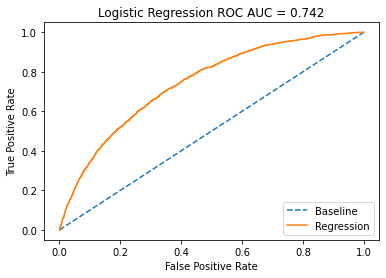

In [80]:
model = LogisticRegression(penalty = 'l2', C=1, class_weight='None', solver ='saga')
model.fit(X_train, Y_train)
probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_val, probs)
roc_auc = roc_auc_score(Y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

ROC AUC = 0.742

Проверим результат на тестовой выборке

In [81]:
X_num_test = StandardScaler().fit_transform(df[df['label'] == 0][num_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(df[df['label'] == 0][cat_cols].values)
X_test = np.hstack([X_num_test, df[df['label'] == 0][bin_cols], X_cat_test])
client_id = df[df['label'] == 0]['client_id']

In [83]:
model = LogisticRegression(penalty = 'l2', C=1, class_weight='None',solver ='saga')
model.fit(X, Y)
probs = model.predict_proba(X_test)
probs = probs[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [84]:
my_submission = pd.DataFrame({'client_id': client_id, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

ValueError: Shape of passed values is (20, 2), indices imply (36349, 2)